In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
%matplotlib inline
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# NBA Foul Analysis with Item Response Theory
Based on Austin Rochford blog post [NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html).

This tutorial shows an application of [Bayesian Item Response Theory](https://www.springer.com/us/book/9781441907417) to NBA basketball foul calls data using [PyMC3](https://pymc3.readthedocs.io/en/latest/index.html). Our scenario is that we observe a binary outcome (a foul being called or not) from an interaction (a basketball play) of two agents with two different roles (the player committing the alleged foul and the player disadvantaged in the play). Moreover, each committing or disadvantaged agent is an individual which might be observed several times (say LeBron James observed committing a foul in more than one play).  Then it might be that not only the agent's role, but also the abilities of the single individual player contribute to the observed outcome. And so we'd like to estimate how much each individual's (latent) ability, along with the role as a committing or  disadvantaged agent, contributes to the observed outcome. 

This is a common and complex multi-agent interaction scenario, with hierarchical structures between the two committing/disadvantaged agents and individuals. Despite its complexity,  Bayesian Item Response Theory combined with modern powerful statistical softwares, allows for quite elegant  and effective modelling options. One of this options employs the [Rasch model](https://en.wikipedia.org/wiki/Rasch_model), which we now discuss in  more detail.


Our data has been collected from the official [NBA Last Two Minutes Reports](https://official.nba.com/2020-21-nba-officiating-last-two-minute-reports/) with game data between 2017 to 2021. Each row `k` of this dataset refers to a play involving two players (the committing and the disadvataged) where a foul has been either called or not. So we model the probability `p_k` that a foul was called in play `k` as a function of the players involved. So we define two latent variables for each player, namely:
- `θ`: which estimates the player's ability of having a foul called when disadvantaged, and
- `b`: which estimates the player's  ability  of having a foul not called when committing.

Note that the higher these player's parameters, the better the outcome for the player's team. These two parameters are then estimated using a standard Rasch model, by assuming the log-odds-ratio of `p_k` equals `θ-b` for the corresponding players involved in play `k`. Also, we place hierarchical hyperpriors on `θ` and `b` to acocunt for shared abilities between players and largely different number of observations for different players.

The analysis is divided in four sections: 

1. Data collection and processing, 
2. Definition and implementation of the Rasch model, 
3. Posterior sampling and convergence checks,
4. Analysis of the posterior results.

# Data collection and processing
We first import the original data set, and restrict ourselves to only a selection of columns. (The original dataset can also be found at [this url](https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv).) 

In [3]:
try:
    orig_df = pd.read_csv('./data/basketball_fouls.csv',low_memory=False)
except FileNotFoundError:
    orig_df = pd.read_csv(pm.get_data('basketball_fouls.csv'),low_memory=False) 
     
df = orig_df[['committing', 'disadvantaged', 'decision']].dropna(axis=0)

We now process our data in three steps:
 1. Create a column called `foul_called` that assigns 1 to a play if a foul was called, and 0 otherwise.
 2. Remove plays where either the committing or the disadvantaged player is not available, which is often given by the team name rather than `None`.
 3. Assign a unique id to all disadvantaged and all committing players and we add two columns to `df`, `committing_player_id` and `disadvantaged_player_id`, which give the id of the committing and disadvantaged players involved in each play.

In [4]:
#1. Create binary called foul variable
def foul_called(decision):
    '''Correct and incorrect noncalls (CNC and INC) take value 0.
    Correct and incorrect calls (CC and IC) take value 1.
    '''
    out = 0
    if (decision == 'CC') | (decision == 'IC'):
        out = 1
    return out
df = df.assign(foul_called=lambda df: df['decision'].apply(foul_called))

#2. Remove plays where less than two players are involved
def player_available(player):
    '''Substitute player with None if player is a team
    name, instead of a player name.
    '''
    if (player != None) & (player != 'Nene'):
        if len(player.split(' ')) == 1:
            player = None
    return player
df = df.assign(committing=lambda df: df['committing'].apply(player_available))
df = df.assign(disadvantaged=lambda df: df['disadvantaged'].apply(player_available))
df = df[df.committing.notna()]
df = df[df.disadvantaged.notna()]

#3. Assign id to committing and disadvantaged players
disadvantaged = list(set(df.disadvantaged))
disadvantaged.sort()
committing = list(set(df.committing))
committing.sort()
def player_id_disadvantaged(player):
    return disadvantaged.index(player)
def player_id_committing(player):
    return committing.index(player)
df = df.assign(committing_player_id=lambda df: 
               df.committing.apply(player_id_committing))
df = df.assign(disadvantaged_player_id=lambda df: 
               df.disadvantaged.apply(player_id_disadvantaged))
df.index.name = 'play_id'

We display the head of our final data frame along with some basic statistics.

In [5]:
print(f'Number of observed plays: {len(df)}')
print(f'Global probability of a foul being called: {100*round(df.foul_called.mean(),3)}%')
print(f'Number of disadvanteged players: {df.disadvantaged_player_id.max()+1}')
print(f'Number of committing players: {df.committing_player_id.max()+1}\n\n')
df.head()

Number of observed plays: 47018
Global probability of a foul being called: 23.3%
Number of disadvanteged players: 772
Number of committing players: 792




,committing,disadvantaged,decision,foul_called,committing_player_id,disadvantaged_player_id
play_id,,,,,,
1,Avery Bradley,Stephen Curry,CNC,0,52,670
3,Isaiah Thomas,Andre Iguodala,CNC,0,297,28
4,Jae Crowder,Harrison Barnes,INC,0,314,263
6,Draymond Green,Isaiah Thomas,CC,1,214,281
7,Avery Bradley,Stephen Curry,CC,1,52,670


# Item Response (Rasch) Model

## Model definition

We denote by:
- $N_d$ and $N_c$ the number of disadvantaged and committing players, respcetively, 
- $K$ the number of plays,
- $k$ a play, 
- $y_k$ the observed call/not call in play $k$,
- $p_k$ the probability of a foul being called in play $k$,
- $i(k)$ the disadvantaged player in play $k$, and by
- $j(k)$ the committing player in play $k$.

We assume that each disadvantaged player is described by the latent variable: 
- $\theta_i$ for $i=1,2,...,N_d$,

and each committing player is described by the latent variable: 
- $b_j$ for $j=1,2,...,N_c$.

Then we model each observation $y_k$ as the result of an independent Bernoulli trial with probability $p_k$, where
$$
p_k =\text{sigmoid}(\eta_k)=\left(1+e^{-\eta_k}\right)^{-1},\quad\text{with}\quad \eta_k=\theta_{i(k)}-b_{j(k)},
$$
for $k=1,2,...,K$, by defining (via a [non-centered parametrisation](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/))
\begin{align*}
\theta_{i}&= \sigma_\theta\Delta_{\theta,i}+\mu_\theta\sim \text{Normal}(\mu_\theta,\sigma_\theta^2),  &i=1,2,...,N_d,\\
b_{j}&= \sigma_b\Delta_{b,j}\sim \text{Normal}(0,\sigma_b^2), &j=1,2,...,N_c,
\end{align*}
with priors/hyperpriors
\begin{align*}
\Delta_{\theta,i}&\sim \text{Normal}(0,1),  &i=1,2,...,N_d,\\
\Delta_{b,j}&\sim \text{Normal}(0,1), &j=1,2,...,N_c,\\
\mu_\theta&\sim \text{Normal}(0,100),\\
\sigma_\theta &\sim \text{HalfCauchy}(2.5),\\
\sigma_b &\sim \text{HalfCauchy}(2.5).
\end{align*}

Note that $p_k$ is always dependent on $\mu_\theta,\,\sigma_\theta$ and $\sigma_b$ ("pooled priors") and also depends on the actual players involved in the play due to  $\Delta_{\theta,i}$ and $\Delta_{b,j}$ ("unpooled priors"). This means our model features partial pooling. Also note that  we normalised the mean of $b_{j}$ to zero.

## PyMC3 implementation
We now implement the model above in PyMC3. Note that, to easily keep track of the players (as we have hundreds of them), we make use of the `coords` argument for `pm.Model` below. (For tutorials on this functionality, see [this blog post]() or  [this PyMC3 example](https://docs.pymc.io/notebooks/data_container.html).)

In [6]:
coords = {'disadvantaged': disadvantaged, 'committing': committing}

with pm.Model(coords=coords) as model:
    
    #Data
    disadvantaged_observed = pm.Data('disadvantaged_observed', df.disadvantaged_player_id)
    committing_observed = pm.Data('committing_observed', df.committing_player_id)
    foul_called_observed = pm.Data('foul_called_observed', df.foul_called)
    
    #Hyperpriors
    μ_θ = pm.Normal('μ_θ',0.,100.)
    σ_θ = pm.HalfCauchy('σ_θ',2.5)
    σ_b = pm.HalfCauchy('σ_b',2.5)
    
    #Priors
    Δ_θ = pm.Normal('Δ_θ', 0., 1., dims='disadvantaged')  
    Δ_b = pm.Normal('Δ_b', 0., 1., dims='committing') 
    
    #Deterministic
    θ = pm.Deterministic('θ', Δ_θ*σ_θ+μ_θ, dims='disadvantaged')
    b = pm.Deterministic('b', Δ_b*σ_b, dims='committing')
    η = pm.Deterministic('η', θ[disadvantaged_observed]-b[committing_observed])
    
    #Likelihood
    y = pm.Bernoulli('y', logit_p=η, observed=foul_called_observed)

We use the method `model_to_graphviz` to plot our model. This shows the hierarchical structure on the variables `θ` and `b`.

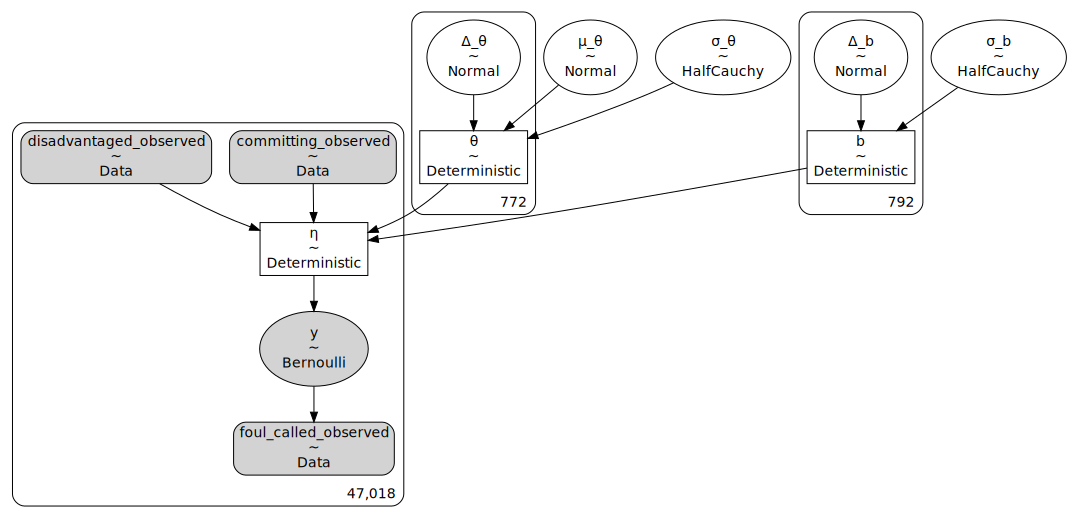

In [7]:
pm.model_to_graphviz(model)

## Sampling and convergence

We now sample from our Rasch model and then plot the energy difference of the obtained trace. Also, we assume our sampler has converged as it passed all automatic PyMC3 convergence checks.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Δ_b, Δ_θ, σ_b, σ_θ, μ_θ]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 233 seconds.


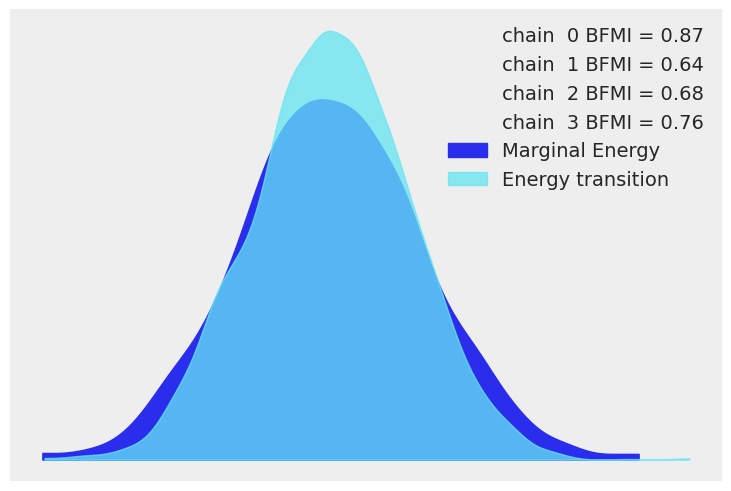

In [8]:
with model:
    trace = pm.sample(1000,
                      tune=1500,
                      return_inferencedata=True, 
                      random_seed=RANDOM_SEED)
az.plot_energy(trace);

## Posterior analysis

### Visualisation of partial pooling
Our first check is to plot 
- y: the difference between the raw mean probability (from the data) and the posterior mean probability for each disadvantaged and committing player
- x: as a function of the number of observations per disadvantaged and committing player.

These plots show, as expected, that the hierarchical structure our model tends to estimate posteriors towards the global mean for players with a low amount of observations, and vice versa. 

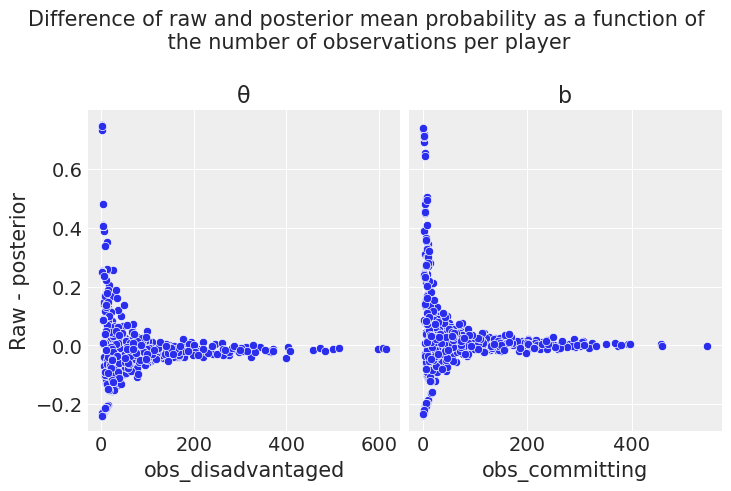

In [9]:
# Global posterior means of μ_θ and μ_b
μ_θ_mean, μ_b_mean = trace.posterior['μ_θ'].mean(), 0
# Raw mean from data of each disadvantaged player
disadvantaged_raw_mean = df.groupby('disadvantaged')['foul_called'].mean()
# Raw mean from data of each committing player
committing_raw_mean = df.groupby('committing')['foul_called'].mean()
# Posterior mean of each disadvantaged player
disadvantaged_posterior_mean = 1/(1+np.exp(
                               -trace.posterior['θ'].mean(dim=['chain','draw']))
                                           ).to_pandas()
# Posterior mean of each committing player
committing_posterior_mean = 1/(1+np.exp(
                            -(μ_θ_mean-trace.posterior['b'].mean(dim=['chain','draw'])))
                                        ).to_pandas()

# Compute difference of Raw and posterior mean for each 
# disadvantaged and committing player
def diff(a,b):
    return a-b
df_disadvantaged = pd.DataFrame(disadvantaged_raw_mean.combine(
                                disadvantaged_posterior_mean, diff),
                                columns=['Raw - posterior mean'])
df_committing = pd.DataFrame(committing_raw_mean.combine(
                             committing_posterior_mean, diff),
                             columns=['Raw - posterior mean'])
# Add the number of observations for each disadvantaged and committing player
df_disadvantaged = df_disadvantaged.assign(
                   obs_disadvantaged=df['disadvantaged'].value_counts())
df_committing = df_committing.assign(
                obs_committing=df['committing'].value_counts())

# Plot the difference between raw and posterior means as a funciton of
# the number of observations
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
fig.suptitle('Difference of raw and posterior mean probability as '
             'a function of\n the number of observations per player\n',
             fontsize=15)
sns.scatterplot(ax=ax1,data=df_disadvantaged,  
             x='obs_disadvantaged', y='Raw - posterior mean')
ax1.set_title('θ')
ax1.set_ylabel('Raw - posterior')
sns.scatterplot(ax=ax2,data=df_committing,  
             x='obs_committing', y='Raw - posterior mean')
ax2.set_title('b')
plt.show()

### Top and bottom  committing and disadvantaged players 
We now plot our results using forest plots. We plot the top and bottom players ranked with respect to `θ` and `b`, respectively.

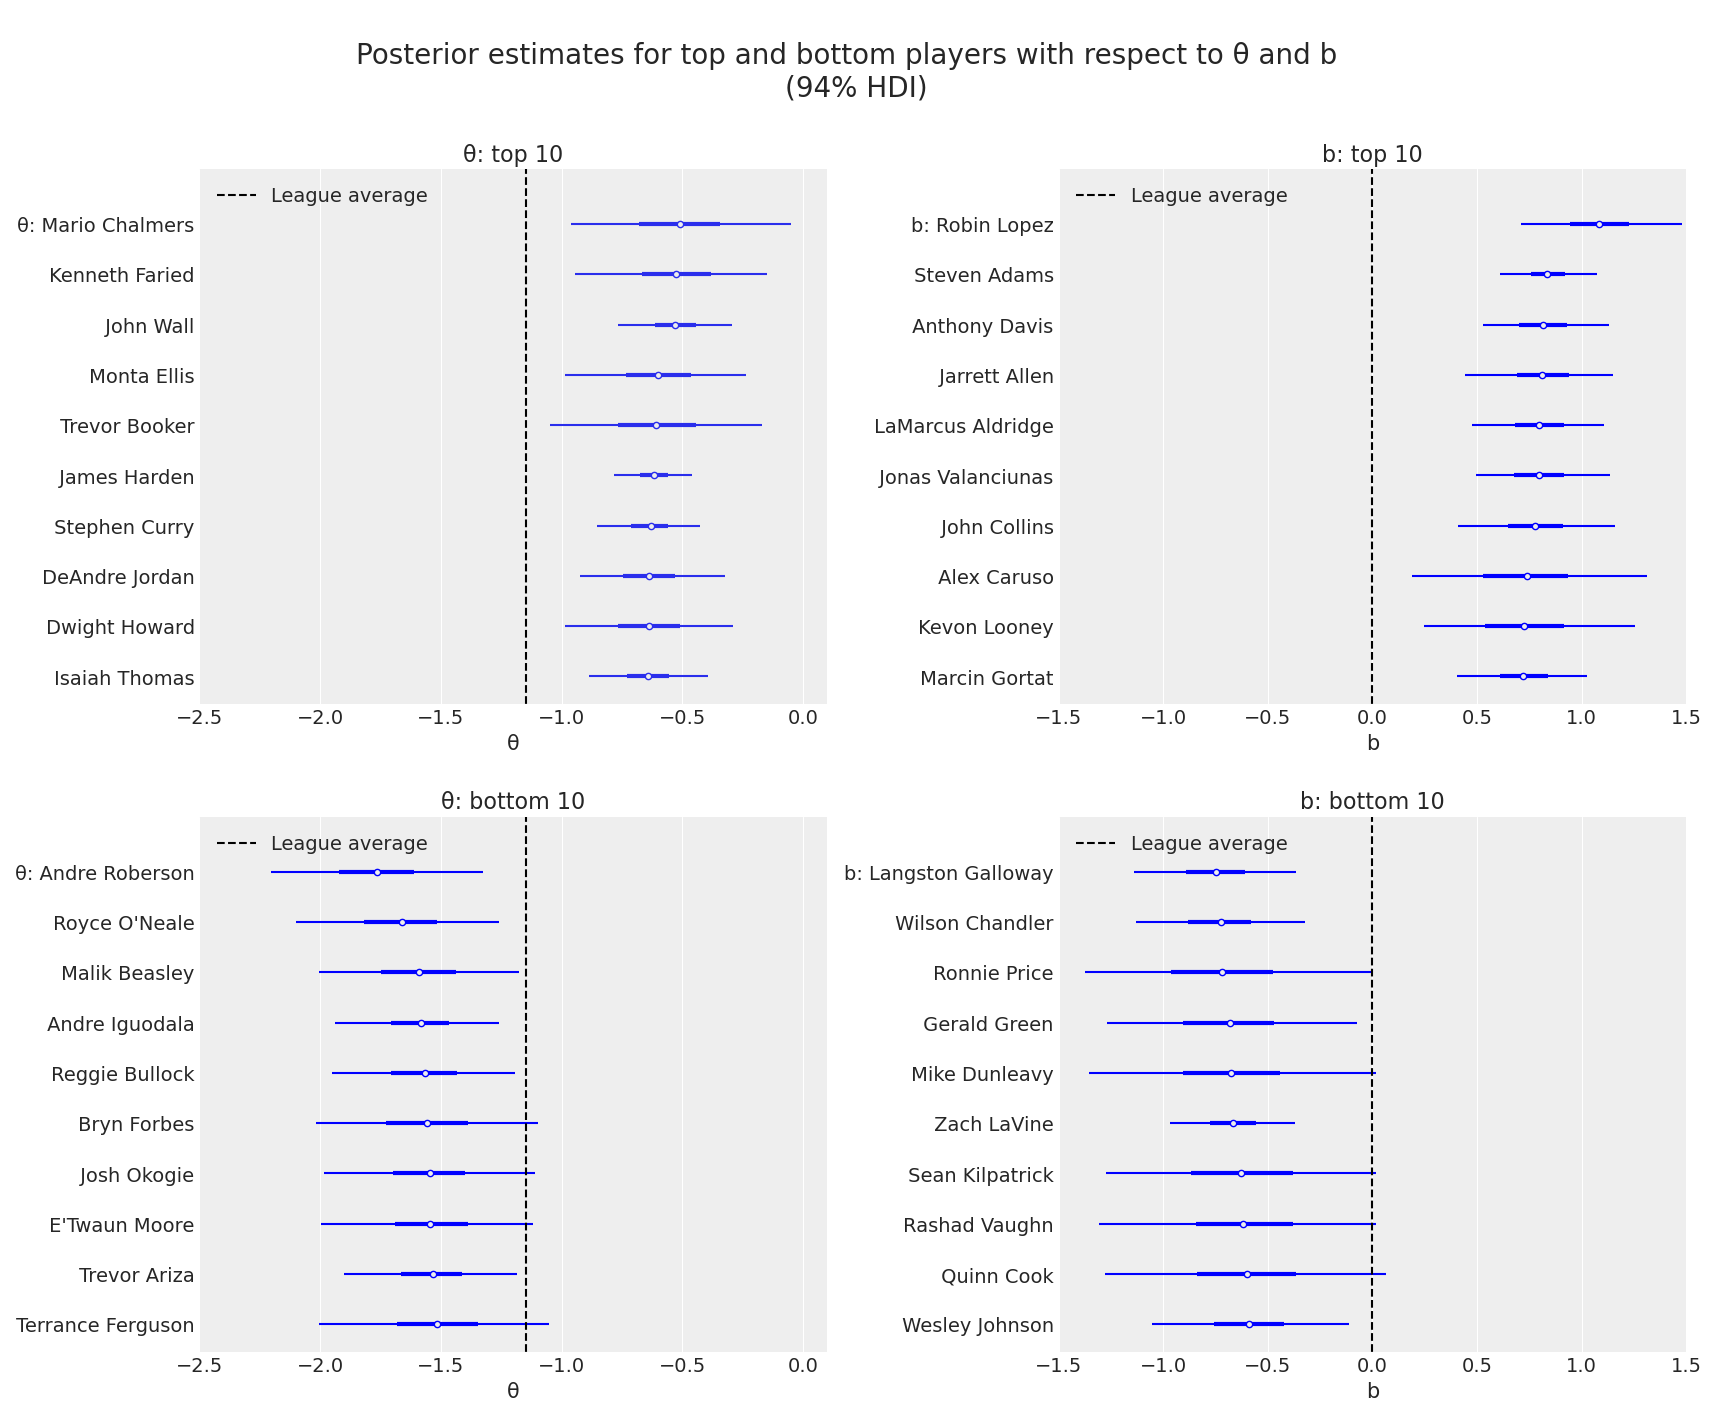

In [10]:
def order_posterior(inferencedata,var,bottom_bool):
    xarray_ = inferencedata.posterior[var].mean(dim=['chain','draw'])
    return xarray_.sortby(xarray_,ascending=bottom_bool)
top_θ, bottom_θ = order_posterior(trace,'θ',False), order_posterior(trace,'θ',True)
top_b, bottom_b = order_posterior(trace,'b',False), order_posterior(trace,'b',True)

amount = 10 #How many top players we want to display in each cathegory

fig = plt.figure(figsize=(17, 14))
fig.suptitle('\nPosterior estimates for top and bottom players '
             'with respect to θ and b  \n(94% HDI)\n',fontsize=20)
θ_top_ax = fig.add_subplot(221)
b_top_ax = fig.add_subplot(222)
θ_bottom_ax = fig.add_subplot(223, sharex=θ_top_ax)
b_bottom_ax = fig.add_subplot(224, sharex=b_top_ax)

#θ: plot top 
az.plot_forest(trace,var_names=['θ'], combined=True,
               coords={'disadvantaged':top_θ[:amount].coords['disadvantaged']},
               ax=θ_top_ax)
θ_top_ax.set_title(f'θ: top {amount}')
θ_top_ax.set_xlabel('θ\n')
#θ_top_ax.axvline(μ_θ_mean,color='black',ls=':', label ='mean') 
θ_top_ax.set_xlim(xmin= -2.5,xmax = 0.1)
θ_top_ax.vlines(μ_θ_mean, -1, amount,
                    'k', '--',
                    label=("League average"))
θ_top_ax.legend(loc=2)


#θ: plot bottom 
az.plot_forest(trace,var_names=['θ'], colors='blue', combined=True,
               coords={'disadvantaged':bottom_θ[:amount].coords['disadvantaged']},
               ax=θ_bottom_ax) 
θ_bottom_ax.set_title(f'θ: bottom {amount}')
θ_bottom_ax.set_xlabel('θ')
#θ_bottom_ax.axvline(μ_θ_mean,color='black',ls=':')
θ_bottom_ax.vlines(μ_θ_mean, -1, amount,
                       'k', '--',
                       label=("League average"))
θ_bottom_ax.legend(loc=2)

#b: plot top 
ax = az.plot_forest(trace,var_names=['b'], colors='blue', combined=True,
                    coords={'committing':top_b[:amount].coords['committing']},
                    ax=b_top_ax) 
b_top_ax.set_title(f'b: top {amount}')
b_top_ax.set_xlabel('b\n')
#b_top_ax.axvline(μ_b_mean,color='black',ls=':') 
b_top_ax.set_xlim(xmin= -1.5,xmax = 1.5)
b_top_ax.vlines(0, -1, amount,
                    'k', '--',
                    label="League average");
b_top_ax.legend(loc=2)

#b: plot bottom 
az.plot_forest(trace,var_names=['b'], colors='blue', combined=True,
               coords={'committing':bottom_b[:amount].coords['committing']},
               ax=b_bottom_ax)
b_bottom_ax.set_title(f'b: bottom {amount}')
b_bottom_ax.set_xlabel('b')
#b_bottom_ax.axvline(μ_b_mean,color='black',ls=':')
b_bottom_ax.vlines(0, -1, amount,
                    'k', '--',
                    label="League average");
b_bottom_ax.legend(loc=2)
plt.show();

### Performance of top committing players as disadvantaged players

The next and final plot shows the `b` scores for the top players with respect to `θ`. This plot suggests that scoring high in `θ` does not correlate with high or low scores in `b`, and that a higher score in `b` is expected from players playing center or forward rather than guards or point guards. Note that this last observation suggests a possibly important additional hierarchical structure to be included in the model.

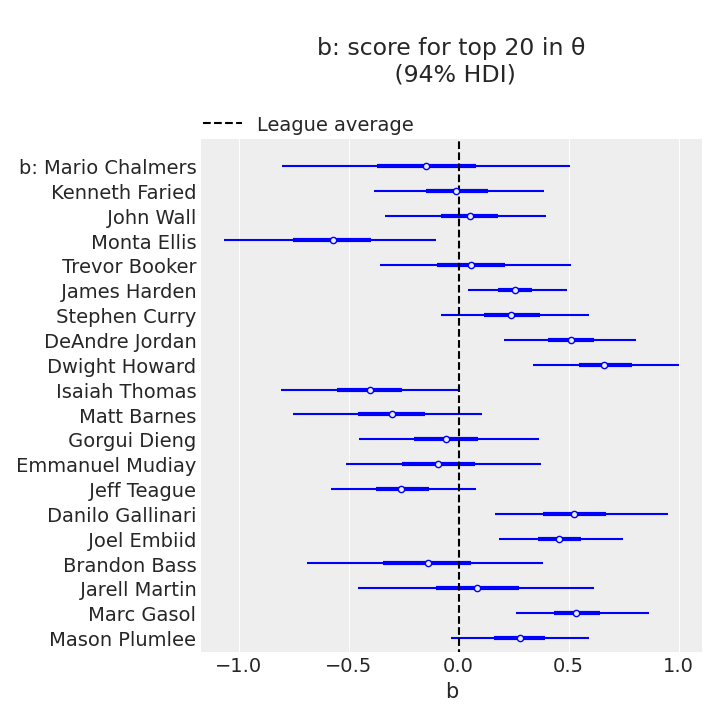

In [11]:
amount = 20 #How many top players we want to display
top_θ_in_committing = set(committing).intersection(
                      set(top_θ[:amount].coords['disadvantaged'].to_dict()['data']))
if len(top_θ_in_committing)<amount:
    print(f'Some players in the top {amount} for θ do not have observations for b.\n',
          'Plot not shown')
else:
    ax = az.plot_forest(trace,var_names=['b'], colors='blue', combined=True,
                 coords={'committing':top_θ[:amount].coords['disadvantaged'].to_dict()['data']},
                 figsize=(7,7))[0]
    ax.set_title(f'\nb: score for top {amount} in θ\n (94% HDI)\n\n',fontsize=17)
    ax.set_xlabel('b')
    ax.vlines(μ_b_mean, -1, amount, color='k',ls='--',label='League average')
    ax.legend(loc='upper right',bbox_to_anchor=(.46, 1.08));

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Sun Jun 13 2021

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

xarray: 0.18.2

numpy     : 1.20.3
seaborn   : 0.11.1
matplotlib: 3.4.2
pymc3     : 3.11.2
pandas    : 1.2.4
arviz     : 0.11.2

Watermark: 2.2.0

